In [1]:
## This file tests the performance of the diff QP with the double integrator system

import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
from solver import quadprog_solve_qp
from double_integrator import DoubleIntegrator
from matplotlib import pyplot as plt

from diff_qp import DiffQP


In [181]:
def TerminalLoss(pred, des):
    A = torch.zeros((des.shape[0], des.shape[0]), dtype = torch.float)
    A[-2:, -2:] = torch.eye(2, dtype = torch.double)
    diff = pred - des
    error += torch.matmul(torch.matmul(diff, A), diff)
    return error
    

In [194]:
class IOC(torch.nn.Module):
    
    def __init__(self, n_col, u_max):
        """
        this class tries to auto tune weights for a simple double integrator problem
        Input:
            n_col : number of collocation points
            u_max : torque limits on the double integrator
        """
        
        super(IOC, self).__init__()
        
        self.eps = 0.1
        
        problem = DoubleIntegrator(n_col, u_max)
        self.A, self.b, self.G, self.h = problem.create_matrices_nn()
        
        self.Q = torch.zeros((3*n_col+2, 3*n_col+2, 3*n_col+2), dtype = torch.float)
        self.R = self.eps * torch.eye(3*n_col+2)
        for i in range(3*n_col+2):
            self.Q[i,i,i] = 1.0
        

        #### This is with simple regression
#         self.weight = torch.nn.Parameter(torch.rand(self.A.shape[1], self.A.shape[1], dtype = float))

        self.use_nn = True
        print("Using NN :", self.use_nn)

        if not self.use_nn:
            self.x = torch.nn.Parameter(torch.ones(2*self.A.shape[1], dtype = torch.float))
        else:
            #### THis is with a neural network to predict weights
            self.fc1 = torch.nn.Linear(4, 60)
            self.fc1.weight.data.fill_(100.0)
            self.fc1.bias.data.fill_(1.0)

            self.out = torch.nn.Linear(60, 2*self.A.shape[1])
            self.out.weight.data.fill_(100.0)
            self.out.bias.data.fill_(1.0)
            
            
    def forward(self, inp):
        
        ### This is with simple regresiion
#         self.Q_torch = 0.5*self.weight.mm(self.weight.t())
    
        ### This is with a neural network
        if self.use_nn:
            x = F.relu(self.fc1(inp))
            x = self.out(x)
        else:
            x = self.x
        
        print(x.shape)
        
        self.weight = x[:self.A.shape[1]]
        self.x_nom = x[self.A.shape[1]:]

        tmp = F.relu(self.weight)
        self.Q_torch = 0.5*torch.matmul(self.Q, tmp) + self.R        
        q = -1 * torch.matmul(self.Q_torch, self.x_nom)

        # setting up the QP
        self.b[-2:] = inp[0:2]

        x_opt[i] = DiffQP.apply(self.Q_torch, q, self.G, self.h, self.A, self.b)
        
        return x_opt

In [195]:
n_col = 10
u_max = 1000


lr = 1e+3
eps = 100

x_init = [0,0]
x_des = torch.zeros((2, 3*n_col + 2)).float()

des_options = [[-3,0], [2,0]]
x_des[:,-2][0] = des_options[0][0]
x_des[:,-2][1] = des_options[1][0]

inp = torch.zeros((2,4)).float()
inp[:,-2][0] = des_options[0][0]
inp[:,-2][1] = des_options[1][0]

ioc = IOC(n_col, u_max)
optimizer = torch.optim.Adam(ioc.parameters(), lr=lr)

for i in range(eps):    
    x_pred = ioc(inp) 
    loss = TerminalLoss(x_pred, x_des)
    print("The loss is :" + str(loss.detach().numpy()), end='\r')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Using NN : True
torch.Size([2, 64])
torch.Size([2, 64])296
torch.Size([2, 64])754
torch.Size([2, 64])056
torch.Size([2, 64])061
torch.Size([2, 64])076
torch.Size([2, 64])643
torch.Size([2, 64])967
torch.Size([2, 64])301
torch.Size([2, 64])204
torch.Size([2, 64])004
torch.Size([2, 64])864
torch.Size([2, 64])085
torch.Size([2, 64])615
torch.Size([2, 64])8804
torch.Size([2, 64])213
torch.Size([2, 64])756
torch.Size([2, 64])09
torch.Size([2, 64])83
torch.Size([2, 64])317
torch.Size([2, 64])216
torch.Size([2, 64])473
torch.Size([2, 64])977
torch.Size([2, 64])951
torch.Size([2, 64])898
torch.Size([2, 64])526
torch.Size([2, 64])284
torch.Size([2, 64])519
torch.Size([2, 64])683
torch.Size([2, 64])056
torch.Size([2, 64])197
torch.Size([2, 64])528
torch.Size([2, 64])96
torch.Size([2, 64])554
torch.Size([2, 64])231
torch.Size([2, 64])851
torch.Size([2, 64])848
torch.Size([2, 64])309
torch.Size([2, 64])625
torch.Size([2, 64])205
torch.Size([2, 64])434
torch.Size([2, 64])158
torch.Size([2, 64])951


In [201]:
inp = torch.tensor(np.hstack((x_init, des_options[0]))).float()
x_pred = ioc(inp) 
x_pred = x_pred.detach().numpy()

tensor([ 0.,  0., -3.,  0.])
torch.Size([64])


IndexError: slice() cannot be applied to a 0-dim tensor.

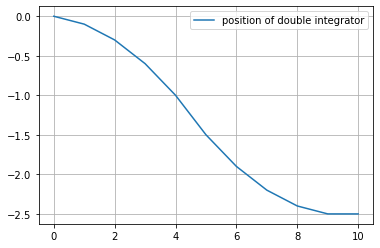

In [145]:
plt.plot(x_pred[0::3], label = "position of double integrator")
plt.grid()
plt.legend()

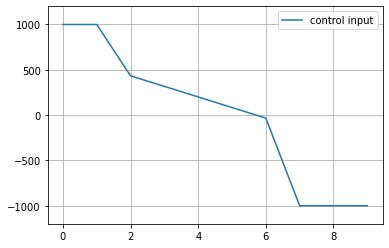

In [235]:
plt.plot(x_pred[2::3], label = "control input")
plt.ylim(-1200,1200)
plt.grid()
plt.legend()

In [56]:
x_train = torch.tensor([[np.hstack((x_init, des_options[0]))], [np.hstack((x_init, des_options[1]))]], dtype = torch.float)
y_train = torch.vstack((weights[0], weights[1])).float()
y_train = y_train.reshape(2, 1, 64)

In [71]:
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        
        self.fc1 = torch.nn.Linear(4, 60)
        self.out = torch.nn.Linear(60, 64)

    def forward(self, x):
       
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [75]:
nn = Net()

lr = 1e-2
eps = 2000
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
loss = torch.nn.MSELoss()

for i in range(eps):
    
    y_pred = nn(x_train)
    error = loss(y_pred, y_train) 
    print("The loss is :" + str(error.detach().numpy()), end='\r')
    optimizer.zero_grad()
    error.backward()
    optimizer.step()

In [102]:
i = 0
y_pred = nn(x_train[i])
print(torch.norm(y_pred - y_train[i]))

tensor(0.2745, grad_fn=<CopyBackwards>)


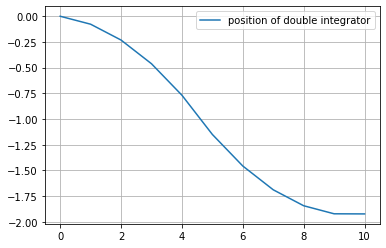

In [125]:
x_train = torch.tensor([0,0,-2,0]).float()
y_pred = nn(x_train).reshape(64)
ioc.x = torch.nn.Parameter(y_pred)

inp = np.hstack((x_init, des_options[i]))
x_pred = ioc(inp) 
x_pred = x_pred.detach().numpy()
plt.plot(x_pred[0::3], label = "position of double integrator")
plt.grid()
plt.legend()

In [135]:
for name, param in ioc.named_parameters():
if param.requires_grad:
    print(name)
    weights.append(param.data)

tensor([ 2.6424e-01,  2.7976e-01, -8.6546e+01,  2.6374e+00,  5.6790e+00,
        -8.7628e+01,  4.4092e+00,  5.6427e+00, -8.8642e+01,  4.8082e+00,
         5.7158e+00, -8.9520e+01,  4.8085e+00,  5.6631e+00, -8.9487e+01,
         4.8127e+00,  5.6589e+00,  7.7152e+00,  4.8335e+00,  5.8686e+00,
         4.5527e+00,  4.8748e+00,  6.1232e+00,  8.4452e-01,  4.8968e+00,
         6.3265e+00, -3.6164e+00,  4.8541e+00,  6.5477e+00, -8.9180e+00,
         4.8697e+00,  6.7781e+00,  1.8195e-01,  2.0263e-01,  1.7827e+03,
         5.5671e+01,  5.7747e+01,  1.6845e+03,  5.5259e+01,  5.5063e+01,
         1.4286e+03,  5.2779e+01,  5.0672e+01,  1.1618e+03,  4.9977e+01,
         4.5720e+01,  8.9029e+02,  4.6840e+01,  4.0811e+01, -8.9394e+02,
         4.4278e+01,  3.7266e+01, -1.1663e+03,  4.2221e+01,  3.4471e+01,
        -1.4209e+03,  4.0300e+01,  3.2184e+01, -1.6634e+03,  3.8720e+01,
         3.0155e+01, -1.7762e+03,  3.7172e+01,  2.8372e+01],
       grad_fn=<SubBackward0>)